# Customer Segmentation

In [134]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Dict
import plotly.express as px
import plotly.figure_factory as ff
from scipy import stats

In [135]:
np.random.seed(0)

## Load Data
Load the data after the feature engineering step. We will be doing customer segmentation based on the train data only to prevent data leakage.

In [136]:
joined_train_data = pd.read_csv('data_exports/joined_train_data_FE.csv')
joined_train_data.head()

,user_id,video_id,time,watch_ratio,user_active_degree,is_lowactive_period,is_live_streamer,is_video_author,follow_user_num,fans_user_num,...,watch_frequency,is_weekend_interaction,is_weekend,time_period,count_afternoon_views,count_evening_views,count_midnight_views,count_morning_views,avg_daily_watch_time,top_3_categories
0,14,148,2020-07-05 05:27:48.378,0.722103,full_active,0,0,1,73,6,...,57.966667,1,0.283496,midnight,118,493,824,304,1.019535e+13,"['民生资讯', '颜值', '明星娱乐']"
1,14,183,2020-07-05 05:28:00.057,1.907377,full_active,0,0,1,73,6,...,57.966667,1,0.283496,midnight,118,493,824,304,1.019535e+13,"['民生资讯', '颜值', '明星娱乐']"
2,14,3649,2020-07-05 05:29:09.479,2.063311,full_active,0,0,1,73,6,...,57.966667,1,0.283496,midnight,118,493,824,304,1.019535e+13,"['民生资讯', '颜值', '明星娱乐']"
3,14,5262,2020-07-05 05:30:43.285,0.566388,full_active,0,0,1,73,6,...,57.966667,1,0.283496,midnight,118,493,824,304,1.019535e+13,"['民生资讯', '颜值', '明星娱乐']"
4,14,8234,2020-07-05 05:35:43.459,0.418364,full_active,0,0,1,73,6,...,57.966667,1,0.283496,midnight,118,493,824,304,1.019535e+13,"['民生资讯', '颜值', '明星娱乐']"


Select the features that we want, and how each of these features may be useful for video recommendations & user segmentation:
- follow_user_num: indicates user engagement level and social connectivity within the platform, helping identify passive consumers versus active community members
- is_new_user: distinguishes between new and established users, capturing differences in platform familiarity and usage patterns based on their user lifecycles
- watch_frequency: reveal the user's consumption habits and platform stickiness, differentiating between casual viewers and power users
- is_weekend: identify temporal usage preferences, helping identify users who watches daily as part of their lives, or only during weekends on their free time
- count_afternoon_views: captures viewing patterns during traditional working/school hours, indicating potential student or professional status and lifestyle patterns
- count_evening_views: shows prime-time consumption habits, helping identify users who follow traditional entertainment consumption patterns
- count_midnight_views: indicates night-time viewing behavior, useful for identifying night owls
- count_morning_views: shows early-day engagement patterns, early birds, helping identify users who integrate the platform into their morning routines
- avg_daily_watch_time: quantifies overall platform engagement intensity, distinguishing between brief browsers and deeply engaged users

In [137]:
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    # Numerical columns
    num_cols = ['follow_user_num', 'is_new_user', 'watch_frequency', 
                'is_weekend', 'count_afternoon_views', 'count_evening_views',
                'count_midnight_views', 'count_morning_views', 'avg_daily_watch_time']
    
    # Select unique users, since the features are all user-based and duplicates
    df_unique = df.drop_duplicates(subset=['user_id'], keep='first')
    
    return df_unique[num_cols]

In [138]:
user_ids = joined_train_data['user_id'].unique()
processed_data = preprocess_data(joined_train_data)

## Principal Component Analysis
PCA (Principal Component Analysis) serves as a crucial preprocessing step before clustering for several reasons. First, it reduces the dimensionality of our feature space while preserving the most important patterns in the data, making clustering more computationally efficient. Importantly, PCA helps address the "curse of dimensionality" where distances between points become less meaningful in high-dimensional spaces, which is also taught in lecture. <br><br>

We will be performing PCA to 3 components, which is sufficiently low-dimension and makes visualization easier too

In [139]:
def perform_pca(df: pd.DataFrame) -> Tuple[pd.DataFrame, PCA]:
    # Standardize the features first
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(df)
    
    # Apply PCA with a total of 3 components
    pca = PCA(n_components=3, random_state=0)
    pca_result = pca.fit_transform(data_scaled)
    
    pca_df = pd.DataFrame(
        data=pca_result,
        columns=['PC1', 'PC2', 'PC3']
    )
    
    return pca_df, pca

pca_df, pca = perform_pca(processed_data)
print("Explained variance ratio:", pca.explained_variance_ratio_)
pca_df.head()

Explained variance ratio: [0.22147934 0.17207752 0.16448131]


,PC1,PC2,PC3
0,1.204071,-0.985254,0.850003
1,-1.853803,0.945212,-0.869072
2,-0.776434,0.660134,0.204221
3,-1.875866,0.431402,0.092723
4,-1.220694,-0.024395,0.200768


### Elbow plot
The elbow plot can serve as a decent gauge for how many clusters we should segment the users into.

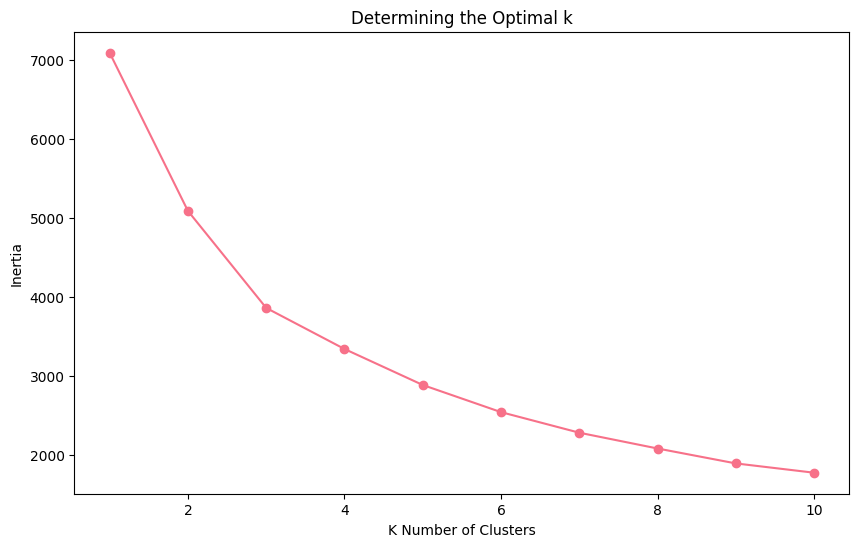

In [159]:
def plot_elbow_method(pca_df: pd.DataFrame, max_clusters: int = 10) -> int:
    """
    Perform and plot elbow method to find optimal number of clusters.
    Returns the optimal number of clusters.
    """
    inertias = []
    
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(pca_df)
        inertias.append(kmeans.inertia_)
    
    # Plot elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_clusters + 1), inertias, marker='o')
    plt.xlabel('K Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Determining the Optimal k')
    plt.show()
    
    return

plot_elbow_method(pca_df)

As we can see here, there is a sharp decrease in gradient after 4 clusters, to a more smooth and linear gradient. Hence, we will be selecting 4 different clusters for K means clustering

## K-Means Clustering
We will be performing K-Means clustering on the components that we have derived

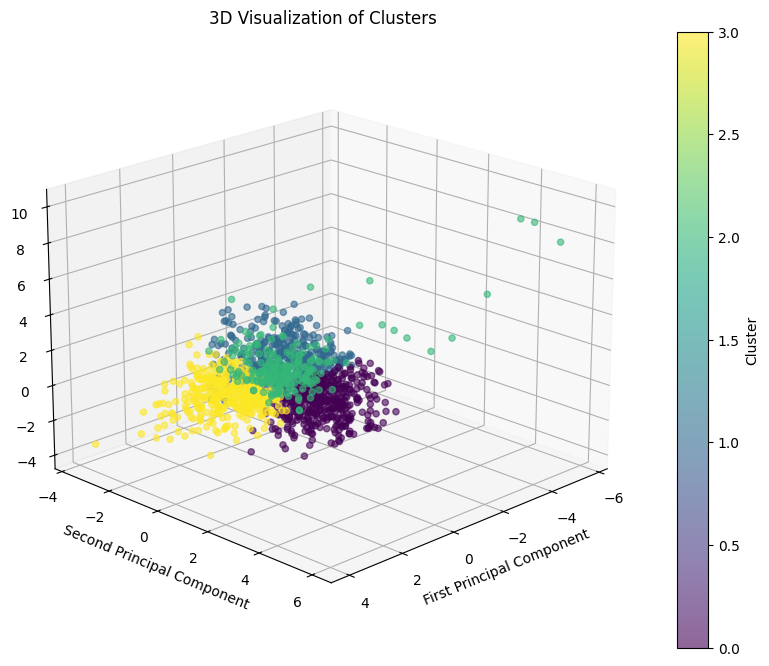

In [141]:
def perform_clustering(pca_df: pd.DataFrame, n_clusters: int) -> np.ndarray:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(pca_df)
    return clusters

def plot_3d_clusters(pca_df: pd.DataFrame, clusters: np.ndarray):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Create scatter plot
    scatter = ax.scatter(pca_df['PC1'], 
                        pca_df['PC2'], 
                        pca_df['PC3'],
                        c=clusters, 
                        cmap='viridis',
                        alpha=0.6)
    
    ax.set_xlabel('First Principal Component')
    ax.set_ylabel('Second Principal Component')
    ax.set_zlabel('Third Principal Component')
    ax.set_title('3D Visualization of Clusters')
    plt.colorbar(scatter, label='Cluster')
    
    # Adjust the viewing angle to visualize more easily
    ax.view_init(elev=20, azim=45)
    
    plt.show()

clusters = perform_clustering(pca_df, n_clusters=4)
plot_3d_clusters(pca_df, clusters)

This shows the clusters in their 3D components after performing PCA

In [142]:
user_cluster_mapping = pd.DataFrame({
        'user_id': user_ids,
        'cluster': clusters
    })
final_df = joined_train_data.merge(user_cluster_mapping, on='user_id', how='left')
final_df.to_csv('data_exports/joined_train_data_segmented.csv', index=False)

## Analysis of Clusters

In this section, we want to identify how each user group is segmented based on the different features we have chosen at the start, which helps us gain insights into how we can potentially tailor our recommendation strategies in real life.

### Distribution of Cluster Counts

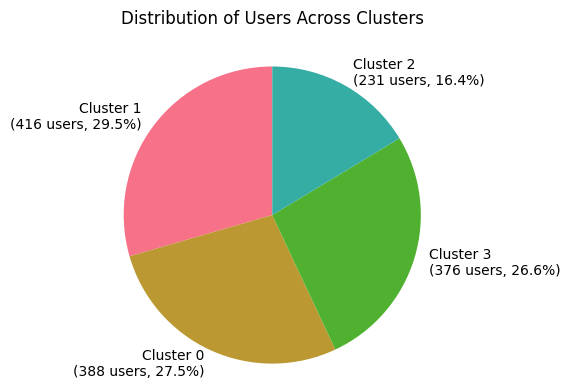

In [154]:
import warnings 
warnings.filterwarnings('ignore')

users = final_df.drop_duplicates(subset=['user_id'], keep='first')
cluster_counts = users['cluster'].value_counts()

# Plot cluster distributions
plt.figure(figsize=(5, 4))
plt.pie(cluster_counts.values, 
        labels=[f'Cluster {i}\n({v:,} users, {(v/len(users)*100):.1f}%)' 
                for i, v in cluster_counts.items()],
        autopct='',
        startangle=90)
plt.title('Distribution of Users Across Clusters', pad=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

### is_new_user (binary)

<Figure size 1200x600 with 0 Axes>

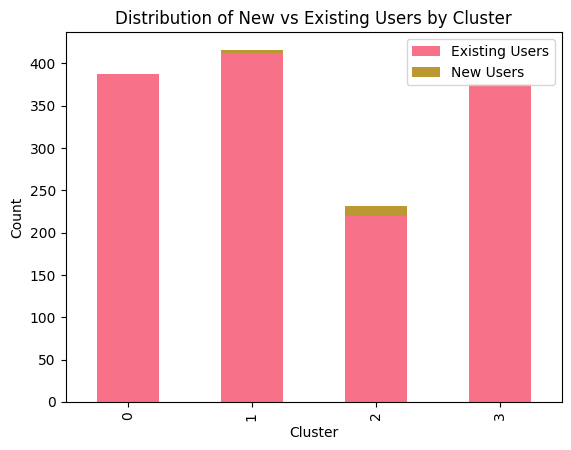

Percentage of new users in each cluster:
cluster
0    0.26
1    0.96
2    4.76
3    0.53
Name: is_new_user, dtype: float64


In [155]:
plt.figure(figsize=(12, 6))
users.groupby(['cluster', 'is_new_user']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Distribution of New vs Existing Users by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(['Existing Users', 'New Users'])
plt.show()

new_user_pct = users.groupby('cluster')['is_new_user'].mean() * 100
print("Percentage of new users in each cluster:")
print(new_user_pct.round(2))

As we can see here, cluster 0, 1, & 3 has low new user counts.
On the other hand, cluster 2 has relatively higher presence of new users

### follow_user_num

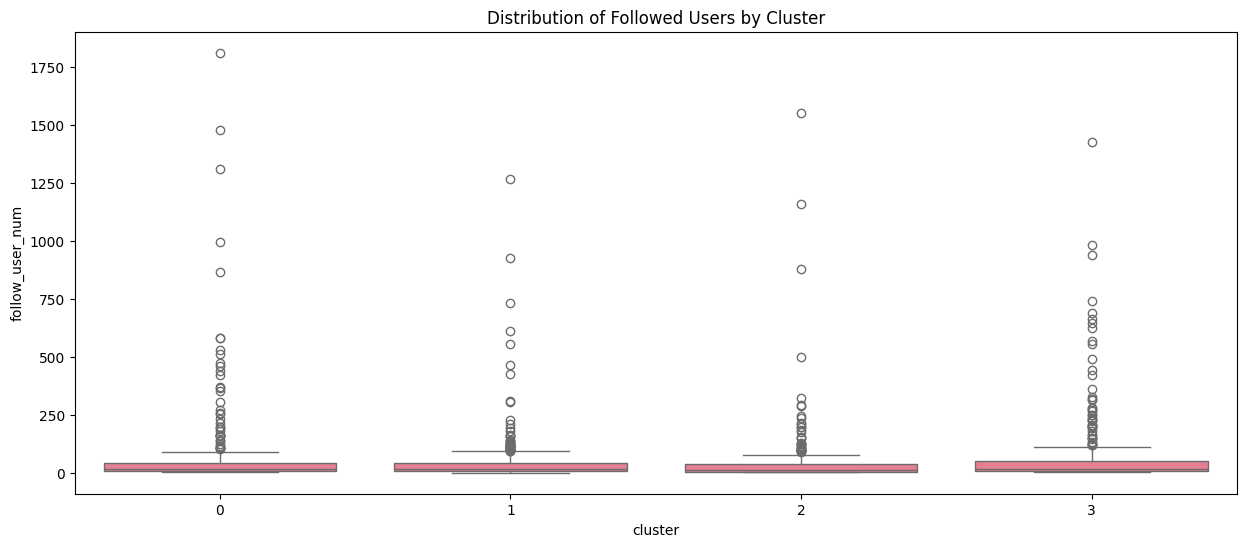

Follower statistics by cluster:
         count   mean     std  min  25%   50%    75%     max
cluster                                                     
0        388.0  60.51  168.82  1.0  9.0  17.0  43.00  1811.0
1        416.0  42.50  103.23  0.0  7.0  15.5  41.00  1265.0
2        231.0  52.16  149.27  1.0  5.0  13.0  37.50  1551.0
3        376.0  61.35  144.99  1.0  6.0  14.0  50.25  1428.0


In [156]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=users, x='cluster', y='follow_user_num')
plt.title('Distribution of Followed Users by Cluster')
plt.show()

print("Follower statistics by cluster:")
print(users.groupby('cluster')['follow_user_num'].describe().round(2))

Here, we can see that cluster 0 & 3 generally have a higher follower counts, which may suggest higher user activity/video posting. <br>
Clusters 1 & 2 has lower average follower counts, suggesting lower user activity.

### watch_frequency
This is the average number of videos watched per day per user

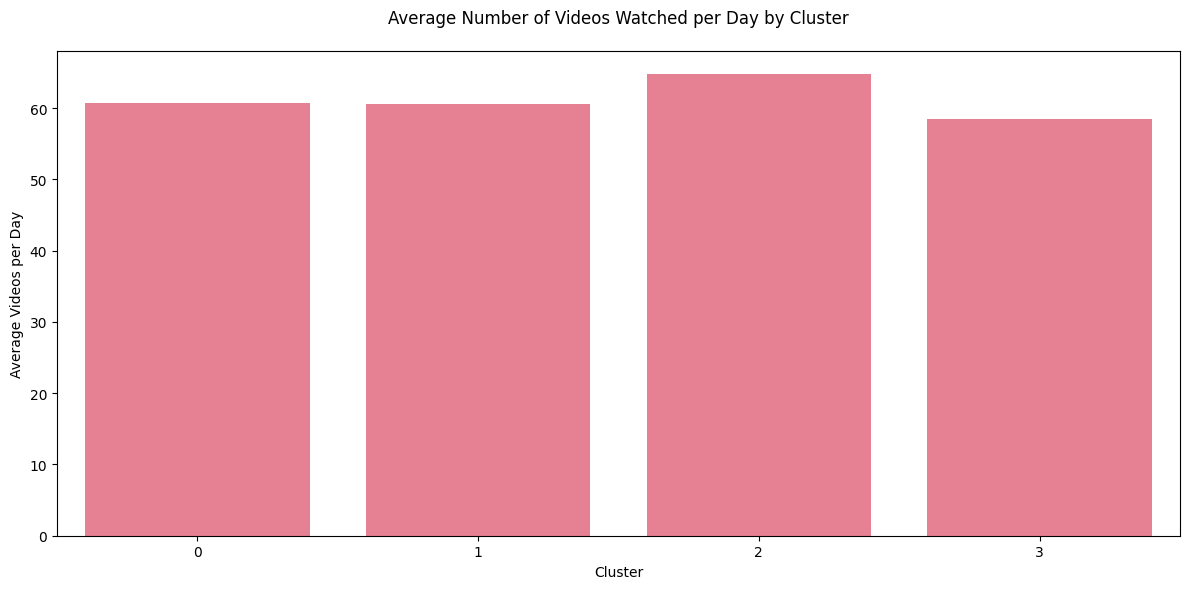

Watch frequency statistics by cluster:
         count   mean   std    min    25%    50%    75%     max
cluster                                                        
0        388.0  60.68  3.28  49.67  58.60  60.83  62.73   68.63
1        416.0  60.58  3.39  49.30  58.22  60.93  63.00   68.90
2        231.0  64.80  5.64  58.37  62.15  63.80  65.55  107.56
3        376.0  58.51  3.09  43.90  56.99  58.77  60.67   65.27


In [157]:
plt.figure(figsize=(12, 6))
sns.barplot(data=users, x='cluster', y='watch_frequency', estimator=np.mean, ci=None)
plt.title('Average Number of Videos Watched per Day by Cluster', pad=20)
plt.xlabel('Cluster')
plt.ylabel('Average Videos per Day')
plt.tight_layout()
plt.show()

print("Watch frequency statistics by cluster:")
print(users.groupby('cluster')['watch_frequency'].describe().round(2))

Watch frequency is pretty even across all the groups. However, cluster 2 appears to have slightly higher than average watch_frequency, while cluster 3 appears to have slightly lower than average watch_frequency

### Viewing Time Patterns
This section analyses count_morning_views, count_afternoon_views, count_evening_views and count_midnight_views for clusters

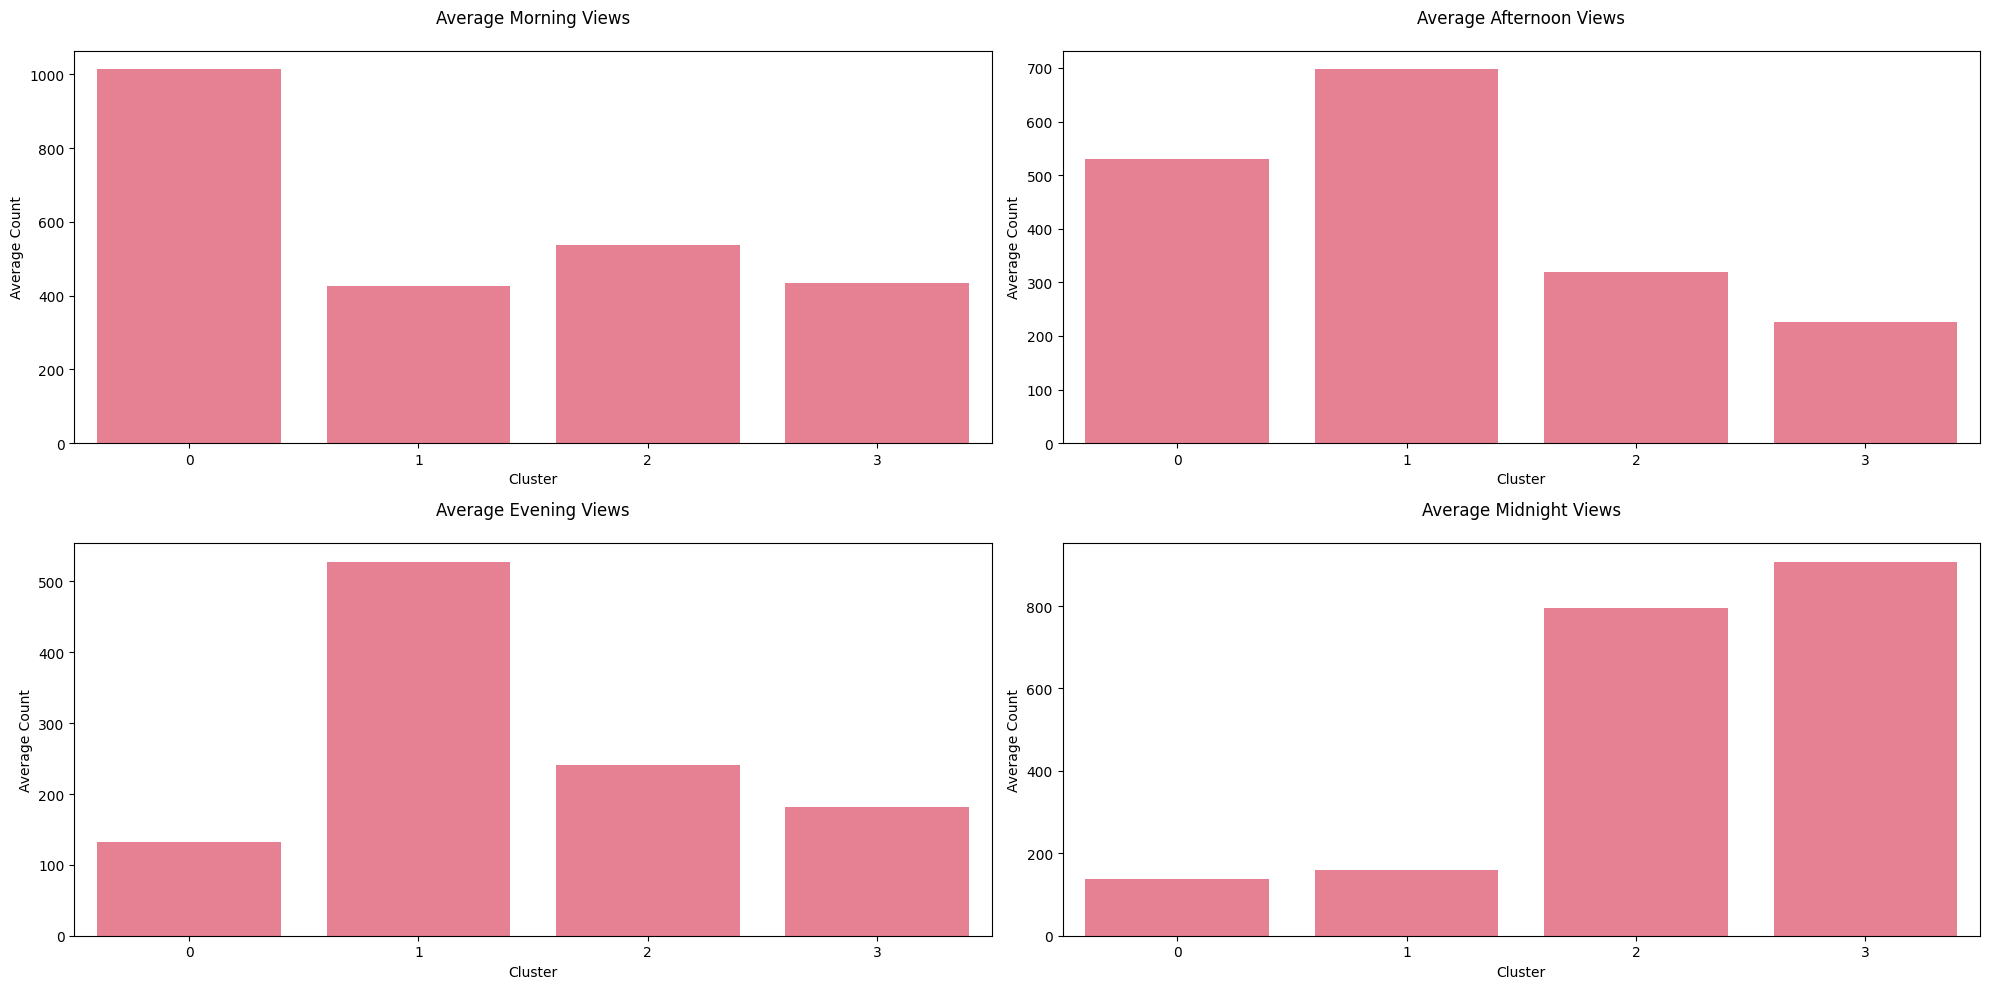

In [158]:
viewing_patterns = ['count_morning_views', 'count_afternoon_views', 
                   'count_evening_views', 'count_midnight_views']

# Create separate bar plots for each viewing pattern
plt.figure(figsize=(20, 10))
for idx, pattern in enumerate(viewing_patterns, 1):
    plt.subplot(2, 2, idx)
    sns.barplot(data=users, x='cluster', y=pattern, estimator=np.mean, ci=None)
    plt.title(f'Average {pattern.replace("count_", "").replace("_", " ").title()}', pad=20)
    plt.xlabel('Cluster')
    plt.ylabel('Average Count')
plt.tight_layout()
plt.show()

This analysis is quite insightful, as it shows that:
- Cluster 0 prefers watching in the morning & afternoon
- Cluster 1 prefers watching in the afternoon & evening
- Cluster 2 watches quite evenly, but more at midnight than average
- Cluster 3 watches very heavily in the midnight

### Weekend vs Weekday

/var/folders/24/w8t485397_n5ygqwgnjns3_80000gn/T/ipykernel_74898/3547144880.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=users, x='cluster', y='is_weekend', estimator=np.mean, ci=None)


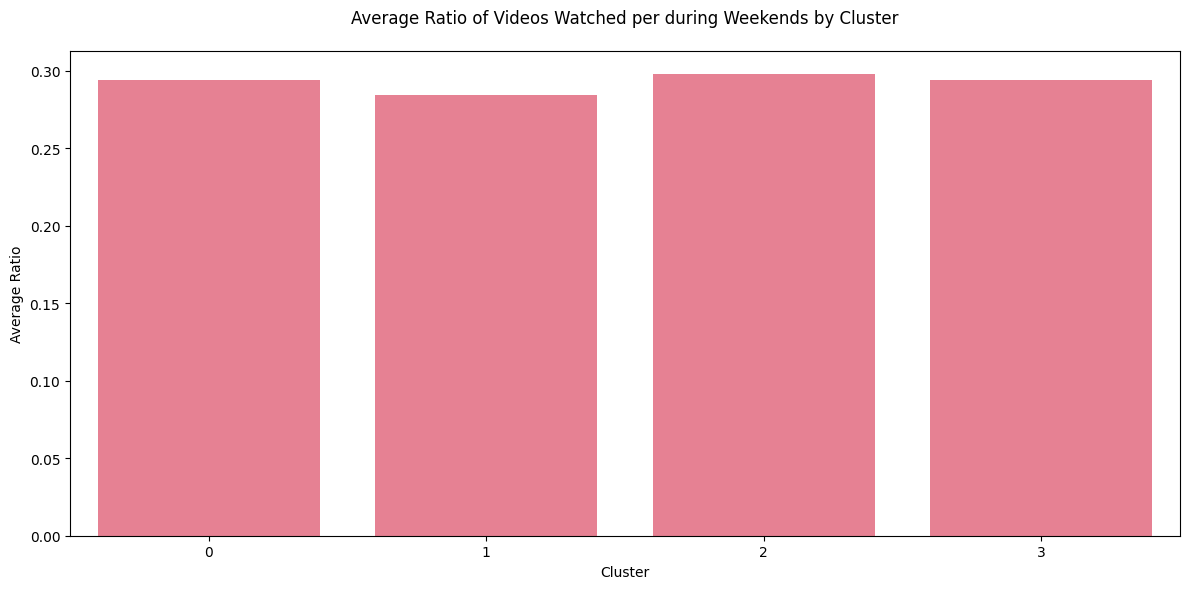

In [148]:
plt.figure(figsize=(12, 6))
sns.barplot(data=users, x='cluster', y='is_weekend', estimator=np.mean)
plt.title('Average Ratio of Videos Watched per during Weekends by Cluster', pad=20)
plt.xlabel('Cluster')
plt.ylabel('Average Ratio')
plt.tight_layout()
plt.show()

This chart is pretty even-looking across the clusters

### Final Summary Statistics

In [149]:
summary_stats = pd.DataFrame()
for cluster in users['cluster'].unique():
    cluster_data = users[users['cluster'] == cluster]
    
    summary_stats[f'Cluster_{cluster}'] = pd.Series({
        'count': len(cluster_data),
        'pct_new_users': cluster_data['is_new_user'].mean() * 100,
        'avg_follow': cluster_data['follow_user_num'].mean(),
        'avg_videos_per_day': cluster_data['watch_frequency'].mean(),
        'pct_weekend': cluster_data['is_weekend'].mean() * 100,
        'avg_morning': cluster_data['count_morning_views'].mean(),
        'avg_afternoon': cluster_data['count_afternoon_views'].mean(),
        'avg_evening': cluster_data['count_evening_views'].mean(),
        'avg_midnight': cluster_data['count_midnight_views'].mean()
    })
print("Cluster Summary Statistics:")
print(summary_stats.round(2))

Cluster Summary Statistics:
                    Cluster_3  Cluster_0  Cluster_1  Cluster_2
count                  376.00     388.00     416.00     231.00
pct_new_users            0.53       0.26       0.96       4.76
avg_follow              61.35      60.51      42.50      52.16
avg_videos_per_day      58.51      60.68      60.58      64.80
pct_weekend             29.41      29.38      28.42      29.79
avg_morning            434.00    1013.57     425.59     538.60
avg_afternoon          226.39     530.31     697.09     318.59
avg_evening            182.25     131.89     527.48     240.55
avg_midnight           906.98     138.10     160.16     795.55
